


### Universidad del Valle de Guatemala
### Data Science
### Proyecto Final
### Grupo 2
### Google - American Sign Language Fingerspelling Recognition



# Dependencias

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import random
import spacy
import re
import pyarrow.parquet as pq
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.data.metrics import bleu_score
from torchmetrics.text import BLEUScore
from torchmetrics.text import WordErrorRate
import torchinfo
from torchinfo import summary

2024-10-28 04:04:37.799821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 04:04:37.799881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 04:04:37.801416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Importar Dataset

In [3]:
data_path = '/kaggle/input/asl-fingerspelling/supplemental_metadata.csv'
df = pd.read_csv(data_path)
df

,path,file_id,sequence_id,participant_id,phrase
0,supplemental_landmarks/33432165.parquet,33432165,1535467051,251,coming up with killer sound bites
1,supplemental_landmarks/33432165.parquet,33432165,1535499058,239,we better investigate this
2,supplemental_landmarks/33432165.parquet,33432165,1535530550,245,interesting observation was made
3,supplemental_landmarks/33432165.parquet,33432165,1535545499,38,victims deserve more redress
4,supplemental_landmarks/33432165.parquet,33432165,1535585216,254,knee bone is connected to the thigh bone
...,...,...,...,...,...
52953,supplemental_landmarks/2100073719.parquet,2100073719,1090866442,239,want to join us for lunch
52954,supplemental_landmarks/2100073719.parquet,2100073719,1090966452,95,this phenomenon will never occur
52955,supplemental_landmarks/2100073719.parquet,2100073719,1091005846,40,the winner of the race
52956,supplemental_landmarks/2100073719.parquet,2100073719,1091011550,241,are you sure you want this


In [4]:
df['phrase'][0]

'coming up with killer sound bites'

In [5]:
max_sentence_len = max(len(x) for x in tqdm(df['phrase']) )
max_sentence_len

  0%|          | 0/52958 [00:00<?, ?it/s]

43

In [6]:
all_sentence_ids = df.sequence_id
all_sentence_ids

0        1535467051
1        1535499058
2        1535530550
3        1535545499
4        1535585216
            ...    
52953    1090866442
52954    1090966452
52955    1091005846
52956    1091011550
52957    1091039755
Name: sequence_id, Length: 52958, dtype: int64

In [7]:
sequence_id, file_id, phrase = df.iloc[1][['sequence_id', 'file_id', 'phrase']]
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{str(33432165)}.parquet",
                                   filters=[[('sequence_id', '=', sequence_id)]]).to_pandas()
print("Full sequence dataset shape is {} -> (no.frames,all mediapipe landmarks)".format(sample_sequence_df.shape))

Full sequence dataset shape is (116, 1630) -> (no.frames,all mediapipe landmarks)


In [8]:
sample_sequence_df

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1535499058,0,0.557461,0.547759,0.551669,0.537038,0.546931,0.547638,0.550804,0.458291,0.550829,...,-0.202968,-0.232654,-0.122672,-0.188781,-0.244209,-0.279699,-0.135030,-0.203018,-0.243293,-0.268739
1535499058,1,0.560021,0.548550,0.552600,0.536685,0.547448,0.547659,0.549692,0.454771,0.549366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535499058,2,0.558341,0.546493,0.550618,0.534712,0.545391,0.545602,0.547658,0.453128,0.547386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535499058,3,0.554317,0.546007,0.549998,0.534040,0.544942,0.545120,0.546959,0.452921,0.546596,...,-0.087421,-0.092110,-0.061267,-0.091615,-0.095231,-0.090560,-0.084755,-0.114311,-0.115203,-0.109521
1535499058,4,0.554339,0.545034,0.548839,0.533062,0.543997,0.544177,0.546049,0.451664,0.545806,...,-0.120278,-0.128472,-0.074288,-0.105535,-0.109645,-0.107629,-0.093643,-0.119939,-0.121273,-0.118810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535499058,111,0.538581,0.542270,0.539801,0.530494,0.542952,0.543157,0.542680,0.437073,0.542996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535499058,112,0.533413,0.540646,0.538193,0.528854,0.541337,0.541539,0.541056,0.435103,0.541474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535499058,113,0.535095,0.540020,0.537502,0.527963,0.540668,0.540753,0.539954,0.433250,0.540242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocesamiento de Señas

## Landmarks de las manos y poses

In [9]:
LPOSE = [13,15,17,19,21]
RPOSE = [14,16,18,20,22]
POSE = LPOSE + RPOSE
POSE

[13, 15, 17, 19, 21, 14, 16, 18, 20, 22]

In [10]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]
FEATURE_COLUMNS = X+Y+Z

In [11]:
len(FEATURE_COLUMNS)

156

In [12]:
FEATURE_COLUMNS[0],FEATURE_COLUMNS[21],FEATURE_COLUMNS[42]

('x_right_hand_0', 'x_left_hand_0', 'x_pose_13')

In [13]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [14]:
len(X_IDX),len(Y_IDX),len(Z_IDX)

(52, 52, 52)

In [15]:
len(RHAND_IDX),len(LHAND_IDX),len(RPOSE_IDX),len(LPOSE_IDX)

(63, 63, 15, 15)

In [16]:
data_to_collect = []

for file_id in tqdm(df.file_id.unique()):
    # Assuming the paths and filtering logic are already correctly defined
    file_df = df.loc[df["file_id"] == file_id]
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{file_id}.parquet",
                               columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    parquet_numpy = parquet_df.to_numpy()
    # Loop through each sequence in file
    for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
        # Assuming frames extraction logic is handled as per your dataset's requirements
        
        frames = parquet_numpy[parquet_df.index == seq_id]

        # Calculate the number of NaN values in each hand landmark
        r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
        l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
        no_nan = max(r_nonan, l_nonan)

        if 2*len(phrase) < no_nan:
            # Prepare data entry for each sequence
            data_entry = {}
            for i, column_name in enumerate(FEATURE_COLUMNS):
                # Flatten and store each feature's values
                data_entry[column_name] = frames[:, i].flatten()
            # Store phrase as a feature
            data_entry["text"] = phrase

            # Append this entry to our collection list
            data_to_collect.append(data_entry)

# Convert collected data into a DataFrame
hands_df = pd.DataFrame(data_to_collect)

  0%|          | 0/53 [00:00<?, ?it/s]

In [17]:
hands_df

,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,...,z_pose_15,z_pose_17,z_pose_19,z_pose_21,z_pose_14,z_pose_16,z_pose_18,z_pose_20,z_pose_22,text
0,"[0.12627919, nan, nan, nan, 0.14516118, nan, n...","[0.22162548, nan, nan, nan, 0.23726308, nan, n...","[0.3116899, nan, nan, nan, 0.3030144, nan, nan...","[0.32735556, nan, nan, nan, 0.30986103, nan, n...","[0.3465665, nan, nan, nan, 0.26768997, nan, na...","[0.28401017, nan, nan, nan, 0.30055636, nan, n...","[0.31710103, nan, nan, nan, 0.3356173, nan, na...","[0.3537532, nan, nan, nan, 0.34955826, nan, na...","[0.39210185, nan, nan, nan, 0.34874672, nan, n...","[0.22299793, nan, nan, nan, 0.24785975, nan, n...",...,"[-1.8782432, -2.014593, -1.9979798, -1.9517139...","[-1.996082, -2.1541927, -2.1341689, -2.0895953...","[-2.0831187, -2.2553644, -2.2344143, -2.182450...","[-1.9251124, -2.0675979, -2.0506275, -2.001739...","[-1.7313651, -1.785233, -1.776082, -1.6682061,...","[-2.5391603, -2.5540237, -2.5318398, -2.42685,...","[-2.706563, -2.7382085, -2.713453, -2.5953994,...","[-2.7103877, -2.791268, -2.7606401, -2.6331105...","[-2.565694, -2.6042914, -2.5794535, -2.468662,...",interesting observation was made
1,"[0.12112225, nan, nan, nan, nan, nan, nan, nan...","[0.19220677, nan, nan, nan, nan, nan, nan, nan...","[0.24808544, nan, nan, nan, nan, nan, nan, nan...","[0.29680595, nan, nan, nan, nan, nan, nan, nan...","[0.34630525, nan, nan, nan, nan, nan, nan, nan...","[0.23295467, nan, nan, nan, nan, nan, nan, nan...","[0.27096337, nan, nan, nan, nan, nan, nan, nan...","[0.29659772, nan, nan, nan, nan, nan, nan, nan...","[0.31991056, nan, nan, nan, nan, nan, nan, nan...","[0.18007426, nan, nan, nan, nan, nan, nan, nan...",...,"[-1.2273145, -1.3403459, -1.3744761, -1.316509...","[-1.37183, -1.5231802, -1.5786595, -1.5135612,...","[-1.4195486, -1.5802692, -1.6407025, -1.607660...","[-1.2488979, -1.3724537, -1.4323127, -1.373501...","[-0.767695, -0.6980978, -0.91199857, -0.362324...","[-2.5289056, -2.4357607, -2.5093262, -1.750044...","[-2.8648975, -2.729822, -2.8152459, -2.000574,...","[-2.8030071, -2.7418332, -2.8230805, -2.072838...","[-2.6938808, -2.5866432, -2.573216, -1.8245065...",victims deserve more redress
2,"[0.24390084, 0.30790052, 0.32837114, 0.3234121...","[0.36093113, 0.4094519, 0.42368704, 0.42003462...","[0.45346805, 0.474035, 0.47549522, 0.4623534, ...","[0.51603353, 0.4821142, 0.49622706, 0.48128706...","[0.5711788, 0.48165095, 0.52215415, 0.50323844...","[0.36588633, 0.35246947, 0.35461983, 0.3655421...","[0.41133797, 0.3992637, 0.36845836, 0.36328876...","[0.47730014, 0.46637493, 0.37989664, 0.3552127...","[0.5446297, 0.5359158, 0.39073873, 0.3529306, ...","[0.29038656, 0.27530742, 0.280807, 0.29128677,...",...,"[-2.5135586, -2.5440166, -2.1812599, -2.884012...","[-2.7424712, -2.7846985, -2.3970606, -3.105609...","[-2.642135, -2.7085454, -2.317745, -2.9706008,...","[-2.4956903, -2.5448883, -2.1771185, -2.857334...","[-1.2203783, -1.3556136, -1.3010726, -1.894791...","[-2.7676752, -3.088335, -3.1074498, -3.6301727...","[-3.0701299, -3.4226608, -3.438098, -3.9434142...","[-2.97185, -3.3631094, -3.3764145, -3.8405125,...","[-2.7836509, -3.1072907, -3.1244304, -3.625440...",knee bone is connected to the thigh bone
3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[-3.0092404, -3.0019593, -2.6647573, -3.171628...","[-3.3719773, -3.3775265, -2.957146, -3.468194,...","[-3.275839, -3.2975707, -2.8503177

In [18]:
# Select columns for 'right' including specified pose columns
right_hand_cols = [col for col in hands_df.columns if 'right_hand' in col]
right_pose_cols = [f'{dim}_pose_{i}' for i in [14, 16, 18, 20, 22] for dim in ['x', 'y', 'z']]
right_cols = right_hand_cols + right_pose_cols

# Select columns for 'left' including specified pose columns
left_hand_cols = [col for col in hands_df.columns if 'left_hand' in col]
left_pose_cols = [f'{dim}_pose_{i}' for i in [13, 15, 17, 19, 21] for dim in ['x', 'y', 'z']]
left_cols = left_hand_cols + left_pose_cols

# Function to concatenate values of given columns for a row
def concat_cols(row, cols):
    return [row[col] for col in cols]

# Concatenate values for 'right' and 'left'
hands_df['right'] = hands_df.apply(concat_cols, cols=right_cols, axis=1)
hands_df['left'] = hands_df.apply(concat_cols, cols=left_cols, axis=1)

# Create a new DataFrame with desired columns
hands_df = hands_df[[ 'right', 'left','text']].copy()


In [19]:
hands_df['right'] = hands_df['right'].apply(lambda x: np.array(x).T)
hands_df['left'] = hands_df['left'].apply(lambda x: np.array(x).T)

## Resize y Secuencia con Padding

In [20]:
def resize_pad_array(arr, target_frames=128, num_features=78):
    current_frames = arr.shape[0]
    if current_frames > target_frames:
        # Truncate the array if it has more than target_frames
        return arr[:target_frames]
    elif current_frames < target_frames:
        # Pad the array with zeros if it has less than target_frames
        padding = np.zeros((target_frames - current_frames, num_features))
        return np.vstack([arr, padding])
    else:
        # Return the array as is if it already matches the target_frames
        return arr

# Apply the normalization function to each row for 'right' and 'left' columns
for index, row in tqdm(hands_df.iterrows()):
    hands_df.at[index, 'right'] = resize_pad_array(row['right'])
    hands_df.at[index, 'left'] = resize_pad_array(row['left'])

# Verify the changes
for index, row in hands_df.iterrows():
    print(f"Right shape: {row['right'].shape}, Left shape: {row['left'].shape}")
    break

0it [00:00, ?it/s]

Right shape: (128, 78), Left shape: (128, 78)


In [21]:
hands_df

,right,left,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",interesting observation was made
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",victims deserve more redress
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",knee bone is connected to the thigh bone
3,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.89611626, 0.81320024, 0.75081563, 0.738649...",stability of the nation
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.7260946, 0.680708, 0.5920537, 0.51955646, ...",all work and no play
...,...,...,...
36705,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.7861494, 0.7373757, 0.7106245, 0.7655896, ...",what you see is what you get
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",want to join us for lunch
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",this phenomenon will never occur
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",the winner of the race


## Mirror Mano Izq.

In [22]:
frame_num = 128
num_rows = len(hands_df.text)
for row in tqdm(range(num_rows)):
    
    for frame in range(frame_num):
        left_row_frame = hands_df.left[row][frame]
        # [:21 x_hand,21:42 y_hand,42:63 z_hand,63:68 x_pose, 68:73 y_pose 73:78 z_pose]
        left_row_frame[:21] = 1 -  left_row_frame[:21]
        left_row_frame[63:68] = 1- left_row_frame[63:68] 
        hands_df.left[row][frame] = left_row_frame

  0%|          | 0/36710 [00:00<?, ?it/s]

In [23]:
hands_df

,right,left,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",interesting observation was made
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",victims deserve more redress
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",knee bone is connected to the thigh bone
3,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.10388374, 0.18679976, 0.24918437, 0.261350...",stability of the nation
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.2739054, 0.319292, 0.4079463, 0.48044354, ...",all work and no play
...,...,...,...
36705,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.21385062, 0.26262432, 0.28937548, 0.234410...",what you see is what you get
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",want to join us for lunch
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",this phenomenon will never occur
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",the winner of the race


## Tomar la mano dominante

In [24]:
def dominant_hand(row):
    lnan = np.count_nonzero(np.isnan(row['left']))
    rnan = np.count_nonzero(np.isnan(row['right']))
    if lnan < rnan:
        return row['left']
    else:
        return row['right']

In [25]:
hands_df['sign'] = hands_df.apply(dominant_hand, axis=1)

In [26]:
hands_df

,right,left,text,sign
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",interesting observation was made,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555..."
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",victims deserve more redress,"[[0.12112225, 0.19220677, 0.24808544, 0.296805..."
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",knee bone is connected to the thigh bone,"[[0.24390084, 0.36093113, 0.45346805, 0.516033..."
3,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.10388374, 0.18679976, 0.24918437, 0.261350...",stability of the nation,"[[0.10388374, 0.18679976, 0.24918437, 0.261350..."
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.2739054, 0.319292, 0.4079463, 0.48044354, ...",all work and no play,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...,...
36705,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.21385062, 0.26262432, 0.28937548, 0.234410...",what you see is what you get,"[[0.21385062, 0.26262432, 0.28937548, 0.234410..."
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",want to join us for lunch,"[[0.16415898501873016, 0.2113991677761078, 0.2..."
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",this phenomenon will never occur,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ..."
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",the winner of the race,"[[0.16856631636619568, 0.1724989116191864, 0.2..."


In [27]:
hands_df = hands_df[['sign','text']].copy()

In [28]:
hands_df

,sign,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...",interesting observation was made
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...",victims deserve more redress
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...",knee bone is connected to the thigh bone
3,"[[0.10388374, 0.18679976, 0.24918437, 0.261350...",stability of the nation
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",all work and no play
...,...,...
36705,"[[0.21385062, 0.26262432, 0.28937548, 0.234410...",what you see is what you get
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...",want to join us for lunch
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...",this phenomenon will never occur
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...",the winner of the race


In [29]:
# hands_df['sign'] = hands_df['sign'].apply(lambda x : x.reshape(-1))

In [30]:
hands_df

,sign,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...",interesting observation was made
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...",victims deserve more redress
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...",knee bone is connected to the thigh bone
3,"[[0.10388374, 0.18679976, 0.24918437, 0.261350...",stability of the nation
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",all work and no play
...,...,...
36705,"[[0.21385062, 0.26262432, 0.28937548, 0.234410...",what you see is what you get
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...",want to join us for lunch
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...",this phenomenon will never occur
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...",the winner of the race


In [31]:
hands_df.sign[0].shape

(128, 78)

## Eliminar valores nulos

In [32]:
hands_df['sign'] = hands_df['sign'].apply(lambda x: np.where(np.isnan(x), 0, x))

In [33]:
hands_df

,sign,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...",interesting observation was made
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...",victims deserve more redress
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...",knee bone is connected to the thigh bone
3,"[[0.10388374, 0.18679976, 0.24918437, 0.261350...",stability of the nation
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",all work and no play
...,...,...
36705,"[[0.21385062, 0.26262432, 0.28937548, 0.234410...",what you see is what you get
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...",want to join us for lunch
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...",this phenomenon will never occur
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...",the winner of the race


# Preprocesamiento de Texto

## Caracter a Número

In [34]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [35]:
print(char_to_num)

{' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58, 'P': 59, '<': 60, '>': 61}


In [36]:
len(char_to_num)

62

In [37]:
hands_df['text'] = hands_df['text'].apply(lambda x: start_token+x+end_token)

In [38]:
hands_df

,sign,text
0,"[[0.12627919, 0.22162548, 0.3116899, 0.3273555...",<interesting observation was made>
1,"[[0.12112225, 0.19220677, 0.24808544, 0.296805...",<victims deserve more redress>
2,"[[0.24390084, 0.36093113, 0.45346805, 0.516033...",<knee bone is connected to the thigh bone>
3,"[[0.10388374, 0.18679976, 0.24918437, 0.261350...",<stability of the nation>
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",<all work and no play>
...,...,...
36705,"[[0.21385062, 0.26262432, 0.28937548, 0.234410...",<what you see is what you get>
36706,"[[0.16415898501873016, 0.2113991677761078, 0.2...",<want to join us for lunch>
36707,"[[0.2442709, 0.3407434, 0.4345789, 0.4310497, ...",<this phenomenon will never occur>
36708,"[[0.16856631636619568, 0.1724989116191864, 0.2...",<the winner of the race>


## Crear un nuevo Dataset

In [39]:
class Sign2TextDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (DataFrame): DataFrame containing the signals and text.
        """
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sign = self.dataframe.iloc[idx, 0]
        text = self.dataframe.iloc[idx, 1]

        # If your signal data is not already a torch tensor, you might want to convert it
        sign_tensor = torch.tensor(sign, dtype=torch.float32)

        # Here, you would handle the text data appropriately.
        # This example assumes you are returning the text as is, but you might
        # want to apply some preprocessing like tokenization.
        
        sample = (sign_tensor, text)

        return sample

In [40]:
dataset = Sign2TextDataset(dataframe=hands_df[:32000])

In [41]:
dataset.__len__()

32000

In [42]:
sign,txt = next(iter(dataset))
print("Sign : ",sign)
print("Text : ",txt)
sign.shape

Sign :  tensor([[ 0.1263,  0.2216,  0.3117,  ...,  0.1026,  0.6219, -2.5657],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0244,  0.7386, -2.6043],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0215,  0.7365, -2.5795],
        ...,
        [ 0.1363,  0.2070,  0.2698,  ...,  0.2339,  0.6988, -2.8207],
        [ 0.1294,  0.2077,  0.2515,  ...,  0.2295,  0.6985, -2.5770],
        [ 0.1327,  0.2077,  0.2505,  ...,  0.2203,  0.6973, -3.0856]])
Text :  <interesting observation was made>


torch.Size([128, 78])

## Tokenización y Vectorización

In [43]:
def vectorization(data):
    processed_data = []
    for (sign , txt) in tqdm(data,total=len(list(data))) :
        sign_tensor = torch.tensor(sign, dtype=torch.float32)
        txt_tensor = torch.tensor([char_to_num[letter] for letter in txt],dtype=torch.long)
        processed_data.append((sign_tensor,txt_tensor))
    return processed_data

In [44]:
vectorized_dataset = vectorization(dataset)
len(vectorized_dataset)

  0%|          | 0/32000 [00:00<?, ?it/s]

32000

In [45]:
sign,txt = next(iter(dataset))
print("Sign : ",sign)
print("Text : ",txt)
vectorized_sign,vectorized_txt = next(iter(vectorized_dataset))
print("Vectorized Sign : ",vectorized_sign)
print("Vectorized Text : ",vectorized_txt)
vectorized_letters = [num_to_char[int(x)] for x in vectorized_txt ]
print('Vectorized Letters :',vectorized_letters)
vectorized_txt_back = ''
for letter in vectorized_letters :
    vectorized_txt_back+=letter
print('Vectorized Text Back:',vectorized_txt_back)

Sign :  tensor([[ 0.1263,  0.2216,  0.3117,  ...,  0.1026,  0.6219, -2.5657],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0244,  0.7386, -2.6043],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0215,  0.7365, -2.5795],
        ...,
        [ 0.1363,  0.2070,  0.2698,  ...,  0.2339,  0.6988, -2.8207],
        [ 0.1294,  0.2077,  0.2515,  ...,  0.2295,  0.6985, -2.5770],
        [ 0.1327,  0.2077,  0.2505,  ...,  0.2203,  0.6973, -3.0856]])
Text :  <interesting observation was made>
Vectorized Sign :  tensor([[ 0.1263,  0.2216,  0.3117,  ...,  0.1026,  0.6219, -2.5657],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0244,  0.7386, -2.6043],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0215,  0.7365, -2.5795],
        ...,
        [ 0.1363,  0.2070,  0.2698,  ...,  0.2339,  0.6988, -2.8207],
        [ 0.1294,  0.2077,  0.2515,  ...,  0.2295,  0.6985, -2.5770],
        [ 0.1327,  0.2077,  0.2505,  ...,  0.2203,  0.6973, -3.0856]])
Vectorized Text :  tensor([60, 40, 45, 51, 36, 49, 36, 50, 51,

In [46]:
total_size = len(vectorized_dataset)
train_size = int(total_size * 0.80)  # 80% of the entire dataset
test_size = total_size - train_size  # The remaining 20% for testing

# Splitting the dataset
train_dataset, test_dataset = random_split(vectorized_dataset, [train_size, test_size])

In [47]:
len(train_dataset),len(test_dataset)

(25600, 6400)

# Crear el Dataloader

In [48]:
BATCH_SIZE = 64

In [49]:
def collate_fn(data):
    sign_data, txt_data = [], []
    
    for sign_vector, txt_vector in data:
        sign_data.append(torch.tensor(sign_vector))  # Ensure sign_vector is in the correct form
        # Assuming txt_vector is already a tensor or a list that can be converted to a tensor
        txt_data.append(torch.tensor(txt_vector, dtype=torch.long))  # Ensure correct type for txt_vector
    
    # Stack sign_data to create a batched tensor
    sign_data = torch.stack(sign_data)
    sign_data = sign_data.transpose(0, 1)
    # Pad txt_data sequences
    txt_data = pad_sequence(sequences=txt_data, padding_value=pad_token_idx)
    
    return sign_data, txt_data

In [50]:
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,collate_fn=collate_fn,)
valid_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,collate_fn=collate_fn)

In [51]:
sign,txt = next(iter(train_dataset))
sign_batch,txt_batch = next(iter(train_dataloader))

print('txt : \n',txt)
txt_vector=[]
for batch_word in txt_batch :
    for word in batch_word:
        txt_vector.append(word.item())
        break
print('Text Vector : \n',txt_vector)
text_letters = [num_to_char[int(x)] for x in txt_vector ]
print('Text Letters: \n',text_letters)
txt_sentence = ''
for letter in text_letters :
    txt_sentence+=letter
print('Text Sentence : \n',txt_sentence)

txt : 
 tensor([60, 51, 39, 36,  0, 47, 49, 40, 34, 36,  0, 46, 37,  0, 38, 32, 50,  0,
        40, 50,  0, 39, 40, 38, 39, 61])
Text Vector : 
 [60, 51, 39, 36, 0, 47, 49, 40, 34, 36, 0, 46, 37, 0, 38, 32, 50, 0, 40, 50, 0, 39, 40, 38, 39, 61, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
Text Letters: 
 ['<', 't', 'h', 'e', ' ', 'p', 'r', 'i', 'c', 'e', ' ', 'o', 'f', ' ', 'g', 'a', 's', ' ', 'i', 's', ' ', 'h', 'i', 'g', 'h', '>', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
Text Sentence : 
 <the price of gas is high>PPPPPPPPPPPPPPPPP


In [52]:
sign_batch.shape,txt_batch.shape

(torch.Size([128, 64, 78]), torch.Size([43, 64]))

In [53]:
nn.Embedding(9984*64,300)

Embedding(638976, 300)

# Construcción del Modelo

## Capa de las LandMarks

In [54]:
class LandmarkEmbedding(nn.Module):
    def __init__(self, num_hid=64, maxlen=100):
        super(LandmarkEmbedding, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_hid, out_channels=num_hid, kernel_size=11, stride=2, padding=5)
        self.conv2 = nn.Conv1d(in_channels=num_hid, out_channels=num_hid, kernel_size=11, stride=2, padding=5)
        self.conv3 = nn.Conv1d(in_channels=num_hid, out_channels=num_hid, kernel_size=11, stride=2, padding=5)
        
        # Define the positional embedding layer
        self.pos_emb = nn.Embedding(num_embeddings=maxlen, embedding_dim=num_hid)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply the convolutional layers with ReLU activation
#         x = x.permute(0 , 2 , 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
#         x = x.permute(0 , 2 , 1)
        
        return x

In [55]:
test_embedding = LandmarkEmbedding()
test_embedding

LandmarkEmbedding(
  (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
  (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
  (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
  (pos_emb): Embedding(100, 64)
  (relu): ReLU()
)

## Encoder

In [56]:
sign_batch.shape

torch.Size([128, 64, 78])

In [57]:
sign_batch.shape

torch.Size([128, 64, 78])

In [58]:
test_embedding(sign_batch).shape

torch.Size([128, 64, 10])

In [59]:
class Encoder(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,dropout_ratio):
        super(Encoder,self).__init__()
        # intialization of hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        
        # intialization of layers
        self.dropout_layer = nn.Dropout(dropout_ratio)
        self.embedding_layer = LandmarkEmbedding()
        self.rnn = nn.LSTM(input_size=10,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout_ratio)
    
    def forward(self,x:torch.Tensor)->torch.Tensor :
#         x = x.transpose(0, 1).unsqueeze(1)
        embedding = self.dropout_layer(self.embedding_layer(x))
#         embedding = embedding.squeeze(1).transpose(0, 2)
        out,(hidden,cell) = self.rnn(embedding)
        
        
        return hidden,cell
        
        

In [60]:
test_encoder = Encoder(input_size=64,hidden_size=1024,num_layers=2,dropout_ratio=0.5)
test_encoder

Encoder(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (embedding_layer): LandmarkEmbedding(
    (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (pos_emb): Embedding(100, 64)
    (relu): ReLU()
  )
  (rnn): LSTM(10, 1024, num_layers=2, dropout=0.5)
)

In [61]:
summary(model=test_encoder,input_data=sign_batch)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [2, 64, 1024]             --
├─LandmarkEmbedding: 1-1                 [128, 64, 10]             6,400
│    └─Conv1d: 2-1                       [128, 64, 39]             45,120
│    └─ReLU: 2-2                         [128, 64, 39]             --
│    └─Conv1d: 2-3                       [128, 64, 20]             45,120
│    └─ReLU: 2-4                         [128, 64, 20]             --
│    └─Conv1d: 2-5                       [128, 64, 10]             45,120
│    └─ReLU: 2-6                         [128, 64, 10]             --
├─Dropout: 1-2                           [128, 64, 10]             --
├─LSTM: 1-3                              [128, 64, 1024]           12,640,256
Total params: 12,782,016
Trainable params: 12,782,016
Non-trainable params: 0
Total mult-adds (G): 103.95
Input size (MB): 2.56
Forward/backward pass size (MB): 71.63
Params size (MB): 51.10
Estimated T

## Decoder

In [62]:
class Decoder(nn.Module):
    def __init__(self,input_size,embedding_size,hidden_size,num_layers,output_size,dropout_ratio):
        super(Decoder,self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout_ratio = dropout_ratio
        
        self.dropout_layer = nn.Dropout(dropout_ratio)
        self.embedding_layer = nn.Embedding(num_embeddings=input_size,embedding_dim=embedding_size)
        self.rnn = nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout_ratio)
        self.fc = nn.Linear(in_features=hidden_size,out_features=output_size)
        
    def forward(self,x:torch.Tensor,hidden,cell)->torch.Tensor:
        x = x.unsqueeze(0)
        embedding = self.dropout_layer(self.embedding_layer(x))
        out,(hidden,cell) = self.rnn(embedding,(hidden,cell))
        predictions = self.fc(out)
        predictions = predictions.squeeze(0)
        
        return predictions,hidden,cell

In [63]:
test_decoder = Decoder(input_size=len(char_to_num),embedding_size = len(char_to_num),hidden_size=1024,num_layers=2,output_size=len(char_to_num),dropout_ratio=0.5)
test_decoder

Decoder(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (embedding_layer): Embedding(62, 62)
  (rnn): LSTM(62, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=62, bias=True)
)

In [64]:
test_hidden,test_cell = test_encoder(sign_batch) 

In [65]:
summary(model=test_decoder,input_data=(txt_batch[0],test_hidden,test_cell))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 62]                  --
├─Embedding: 1-1                         [1, 64, 62]               3,844
├─Dropout: 1-2                           [1, 64, 62]               --
├─LSTM: 1-3                              [1, 64, 1024]             12,853,248
├─Linear: 1-4                            [1, 64, 62]               63,550
Total params: 12,920,642
Trainable params: 12,920,642
Non-trainable params: 0
Total mult-adds (M): 822.68
Input size (MB): 1.07
Forward/backward pass size (MB): 0.59
Params size (MB): 51.68
Estimated Total Size (MB): 53.34

## Modelo Seq2Seq 

In [66]:
class Seq2Seq(nn.Module):
    def __init__(self,enocder,decoder):
        super(Seq2Seq,self).__init__()
        self.encoder = enocder
        self.decoder = decoder
        
    def forward(self,source,target,teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(char_to_num)
        
        outputs = torch.zeros(target_len,batch_size,target_vocab_size)
        
        hidden,cell = self.encoder(source)
        
        x = target[0]
        for t in range(1,target_len):
            output,hidden,cell = self.decoder(x,hidden,cell)
            
            outputs[t] = output
            best_gess = output.argmax(1)
            
            x = target[t] if random.random() < teacher_force_ratio else best_gess
            
        return outputs

In [67]:
test_seq2seq = Seq2Seq(test_encoder,test_decoder)
test_seq2seq

Seq2Seq(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): LandmarkEmbedding(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (pos_emb): Embedding(100, 64)
      (relu): ReLU()
    )
    (rnn): LSTM(10, 1024, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): Embedding(62, 62)
    (rnn): LSTM(62, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=62, bias=True)
  )
)

In [68]:
txt_batch[0].shape

torch.Size([64])

In [69]:
summary(model=test_seq2seq,input_data=(sign_batch,txt_batch,0.5))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [43, 64, 62]              --
├─Encoder: 1-1                           [2, 64, 1024]             --
│    └─LandmarkEmbedding: 2-1            [128, 64, 10]             6,400
│    │    └─Conv1d: 3-1                  [128, 64, 39]             45,120
│    │    └─ReLU: 3-2                    [128, 64, 39]             --
│    │    └─Conv1d: 3-3                  [128, 64, 20]             45,120
│    │    └─ReLU: 3-4                    [128, 64, 20]             --
│    │    └─Conv1d: 3-5                  [128, 64, 10]             45,120
│    │    └─ReLU: 3-6                    [128, 64, 10]             --
│    └─Dropout: 2-2                      [128, 64, 10]             --
│    └─LSTM: 2-3                         [128, 64, 1024]           12,640,256
├─Decoder: 1-2                           [64, 62]                  --
│    └─Embedding: 2-4                    [1, 64, 62]          

# Entrenamiento del modelo

## Encoder HyperParametros

In [70]:
num_hid=64
encoder_input_size = num_hid
encoder_hidden_size = 1024
encoder_num_layers = 2
encoder_dropout_ratio = 0.5

In [71]:
encoder = Encoder(input_size=encoder_input_size,
                  hidden_size=encoder_hidden_size,
                  num_layers=encoder_num_layers,
                  dropout_ratio=encoder_dropout_ratio).to(device)
encoder

Encoder(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (embedding_layer): LandmarkEmbedding(
    (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
    (pos_emb): Embedding(100, 64)
    (relu): ReLU()
  )
  (rnn): LSTM(10, 1024, num_layers=2, dropout=0.5)
)

## Decoder HyperParametros

In [72]:
decoder_input_size = len(char_to_num)
decoder_embedding_size = len(char_to_num)
decoder_hidden_size = 1024
decoder_num_layers = 2
decoder_output_size = len(char_to_num)
decoder_dropout_ratio = 0.5

In [73]:
decoder = Decoder(input_size=decoder_input_size,
                  embedding_size = decoder_embedding_size,
                  hidden_size=decoder_hidden_size,
                  num_layers=decoder_num_layers,
                  output_size=decoder_output_size,
                  dropout_ratio=decoder_dropout_ratio).to(device)
decoder

Decoder(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (embedding_layer): Embedding(62, 62)
  (rnn): LSTM(62, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=62, bias=True)
)

In [74]:
model = Seq2Seq(enocder=encoder,decoder=decoder).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): LandmarkEmbedding(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (pos_emb): Embedding(100, 64)
      (relu): ReLU()
    )
    (rnn): LSTM(10, 1024, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): Embedding(62, 62)
    (rnn): LSTM(62, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=62, bias=True)
  )
)

## HyperParamétros del Modelo

In [75]:
learning_rate = 0.001
epochs=20

## Función de Pérdida y Optimizador

In [76]:
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [77]:
load_model = False
save_model = True

In [78]:
# Tensorboard to get nice loss plot
writer = SummaryWriter(f"runs/seq2seq attention/loss_plot")
step = 0

## Funciones Auxiliares

In [79]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [80]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Entrenamiento

In [81]:
def train_step (model,train_dataloader,optimizer,loss_fn,device,step):
    model.to(device)
    train_loss = 0
    
    model.train()
    model.to(device)
    
    for i,(source,target) in enumerate(tqdm(train_dataloader,desc='Trainig Loop : ')):
        
        source,target = source.to(device),target.to(device)
        
        # training loss
        output = model(source,target)
        output = output[1:].reshape(-1,output.shape[2])
        target = target[1:].reshape(-1)
        loss = loss_fn(output.to(device),target.to(device))
        train_loss += loss
        
        # get optimizer ready
        optimizer.zero_grad()
        
        # back propagation
        loss.backward()
        
        # weights clipping to avoid exploding
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(),max_norm=1)
        
        # gradient descent
        optimizer.step()
        
        # plot to tensorboard
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1
        
        
    train_loss = train_loss/len(train_dataloader)
    
    return train_loss    

## Testing

In [82]:
def test_step(model,test_dataloader,loss_fn,device):
    model.to(device)
    test_loss = 0

    model.eval()
    all_target_vectors = []
    all_output_vectors = []
    for i,(source,target) in enumerate(tqdm(valid_dataloader,desc='Testing Loop : ')):
        source,target = source.to(device),target.to(device)
        with torch.inference_mode():
            output = model(source,target)
            
            target_vector=[]
            for batch_word in target :
                for word in batch_word:
                    target_vector.append(word.item())
                    break
            output_vector=[]
            for batch_word in output.argmax(2) :
                for word in batch_word:
                    output_vector.append(word.item())
                    break
            all_target_vectors.append(target_vector)
            all_output_vectors.append(output_vector)
            
            output = output.reshape(-1,output.shape[2])
            target = target.reshape(-1)
            loss = loss_fn(output.to(device),target.to(device))
            test_loss += loss
    all_target_sentences = []
    for target_vector in all_target_vectors:
        target_letters = [num_to_char[int(x)] for x in target_vector ]
        target_sentence = ''
        for letter in target_letters :
            target_sentence+=letter
        all_target_sentences.append(target_sentence)

    all_output_sentences = []
    for output_vector in all_output_vectors:    
        output_letters = [num_to_char[int(x)] for x in output_vector ]
        output_sentence = '<'
        for i,letter in enumerate(output_letters) :
            if i == 0:
                continue
                
            output_sentence+=letter
            
            if letter =='>':
                break
        all_output_sentences.append(output_sentence)
        
    for i in range(len(all_target_sentences[:10])):    
        print(f'Original Sentence  {i+1} : ',all_target_sentences[i])
        print(f'Predicted Sentence {i+1} : ',all_output_sentences[i])
    
    test_loss = test_loss/len(valid_dataloader)

    return test_loss
    

## Entrenamiento y Testing

In [83]:
def train(model,train_dataloader,test_dataloader,epochs,optimizer,loss_fn,device):
    load_model = False
    if load_model:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    results ={
        'train_loss':[],
        'test_loss':[],
    }
    model.to(device)
    epoch = 0
    step = 0
    best_metric_value = float('inf')  # Initialize with a large value for loss or a small value for accuracy
    best_model_state_dict = None
    for epoch in tqdm(range(epochs) ,desc=f'Epoch :'):
        train_loss = train_step(model=model,
                                train_dataloader=train_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,step=step)
        
        test_loss = test_step(model=model,
                                test_dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        if test_loss < best_metric_value:
            best_metric_value = test_loss
            best_model_state_dict = model.state_dict()
            best_model_path = 'best_Seq2Seq_model.pth'
            torch.save(best_model_state_dict, best_model_path)
            
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        print(f'Epoch : {epoch+1} | Train loss : {train_loss:.4f} | Test loss : {test_loss:.4f}')

        
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)

        model.eval()
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
    
    return results
    

In [84]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=valid_dataloader,
                epochs=epochs,
                optimizer=optimizer,
                loss_fn=loss_fn,
                device=device)

Epoch ::   0%|          | 0/20 [00:00<?, ?it/s]

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txery a  a   or  o  oe e t>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <tete in     to  e  oe  ot>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <th fover  o   afe os tenee>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tot  e  e   e  o   oanteee>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toet     n  he  on  r  oo   l>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <thet in   ot     a t     oos>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the  ou     e ao  o etor toen>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t  ootee in  he  one  ofn the u>
Original Sentence  9 :

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <thery on  areoem tn    boease>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thke i good deek ng the r  souss>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite suert is vecked>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thkeiaree  ae a are ene e >
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <tood ng  a aoe rattest tf the cauer>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <treying t  on thr the r  ooslsttt>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the caars aae andtn eto  tord rght>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t goayse  s a v teght iistat

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txery sapla from the raiee>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thne megood weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite suort is cacketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <the coalapse  ie to erkeer woll do>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thet io es verywerd to of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyers a  ting sudft  for td arersserre>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the st tht k is  ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t goayce in the right directio

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <thery apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thke a coffee  bnep  tim the whilts>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <th favorite webrt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <temblells are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thavele is the facdest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <treasit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the cariont s are sk for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thcaance in the right direction>
Original Se

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <the e caeed persenoery tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thke me ood weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the cot a e iubs  os racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tet yidls are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <tet yourou tha pardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <thcabj quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <the csgepws goo sight direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txery apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <theermetood weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite web browtricket>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thetbills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thevede is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <theyers again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t gogk quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thcoance in the right direction>
Original Sentence  9 :  <olympi

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <thery apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te is jeduting to dom suse>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the ivorite pubje is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tet bills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <teanite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <theasrt again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t guck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t guck t in the right direction>
Original Sentence  9

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <the cottrietor was bxv busstionsn>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thke a cofd weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the cssault tooone s ovmmed>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thkhiills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thevelinto the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyert again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the ck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t  oance in the right direction>
Original Sentence  9 :  <

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txercise is gor  every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <tene a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the  ssre e witn was not er>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tet aboar th  sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thevele is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleaert again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <thco n toccks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t  oodce in the right direction>
Original Sentence  9 :  <olympi

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txectionsle from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <the  a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <theaavorite pubjt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thne ills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <the cno is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <the  mt again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the yo quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t goance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <tlect spple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te e a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite wubrt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tos bills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thevell is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <theyeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <thlo k quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <the l we pl the raght direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <the ebodple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te caa good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the avorite place is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tos bills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toonite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyert again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the ck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <theoance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <tvery apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thke a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite subjecis racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tet bills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <thevede is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleaeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <the ck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thcoance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <the e wiple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te is still on  eed>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <th favorite wubje is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <toodyoud r mouseat monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toanite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyert again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <thgood the ks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t loance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <theryoneple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <theer  good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite wuort is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tom bills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toeatte is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tlease  again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <thgock quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <theoance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txery spple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thni a cood weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <thenovorite wuort is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tet yills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <teanite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyert again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t guck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t goance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <txerconpple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te i a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <the avorite wubjt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thetyills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <tamnite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <theaeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t goch quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thenance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <the e apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <thee m good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <th favorite wubrt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <the caggestne sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <tet abo on the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <thet isic ain sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t  uck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <t  oance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <tlerybodple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <te e a good weekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <ty favorite web t is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <thetbills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toaat disturbatbirdest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleaeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t good respons  to e for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thcoance in the right direction>
Original Sentence  9 :  <ol

Trainig Loop :   0%|          | 0/400 [00:00<?, ?it/s]

Testing Loop :   0%|          | 0/100 [00:00<?, ?it/s]

Original Sentence  1 :  <every apple from every tree>PPPPPPPPPPPPPPP
Predicted Sentence 1 :  <thery apple from every tree>
Original Sentence  2 :  <have a good weekend>PPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 2 :  <the  is  n  neekend>
Original Sentence  3 :  <my favorite sport is racketball>PPPPPPP
Predicted Sentence 3 :  <th favorite subrt is racketball>
Original Sentence  4 :  <gas bills are sent monthly>PPPPPPPPPPPPPPPPP
Predicted Sentence 4 :  <tombbills are sent monthly>
Original Sentence  5 :  <granite is the hardest of all rocks>PPPPPPP
Predicted Sentence 5 :  <toanite is the hardest of all rocks>
Original Sentence  6 :  <play it again sam>PPPPPPPPPPPPPPPPPPPPPPPP
Predicted Sentence 6 :  <tleyeit again sam>
Original Sentence  7 :  <a duck quacks to ask for food>PPPPPPPPPPP
Predicted Sentence 7 :  <t tuck quacks to ask for food>
Original Sentence  8 :  <a glance in the right direction>PPPPPPPPP
Predicted Sentence 8 :  <thcood e in the right direction>
Original Sentence  9 :  <ol

# Gráficas de Pérdida

In [85]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_accuracy": [...],
             "test_loss": [...],
             "test_accuracy": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))
    loss = [x.cpu().detach().numpy() for x in loss]
    test_loss = [x.cpu().detach().numpy() for x in test_loss]
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


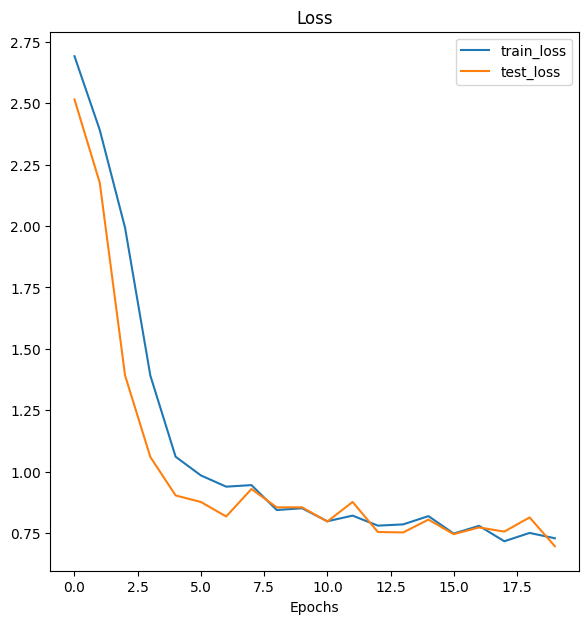

In [86]:
plot_loss_curves(results)

In [87]:
best_model = Seq2Seq(encoder,decoder)

In [88]:
check_point = torch.load('best_Seq2Seq_model.pth')

In [89]:
check_point.keys()

odict_keys(['encoder.embedding_layer.conv1.weight', 'encoder.embedding_layer.conv1.bias', 'encoder.embedding_layer.conv2.weight', 'encoder.embedding_layer.conv2.bias', 'encoder.embedding_layer.conv3.weight', 'encoder.embedding_layer.conv3.bias', 'encoder.embedding_layer.pos_emb.weight', 'encoder.rnn.weight_ih_l0', 'encoder.rnn.weight_hh_l0', 'encoder.rnn.bias_ih_l0', 'encoder.rnn.bias_hh_l0', 'encoder.rnn.weight_ih_l1', 'encoder.rnn.weight_hh_l1', 'encoder.rnn.bias_ih_l1', 'encoder.rnn.bias_hh_l1', 'decoder.embedding_layer.weight', 'decoder.rnn.weight_ih_l0', 'decoder.rnn.weight_hh_l0', 'decoder.rnn.bias_ih_l0', 'decoder.rnn.bias_hh_l0', 'decoder.rnn.weight_ih_l1', 'decoder.rnn.weight_hh_l1', 'decoder.rnn.bias_ih_l1', 'decoder.rnn.bias_hh_l1', 'decoder.fc.weight', 'decoder.fc.bias'])

In [90]:
best_model.load_state_dict(check_point)

<All keys matched successfully>

In [91]:
best_model

Seq2Seq(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): LandmarkEmbedding(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (conv3): Conv1d(64, 64, kernel_size=(11,), stride=(2,), padding=(5,))
      (pos_emb): Embedding(100, 64)
      (relu): ReLU()
    )
    (rnn): LSTM(10, 1024, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (embedding_layer): Embedding(62, 62)
    (rnn): LSTM(62, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=62, bias=True)
  )
)

# Bleu Score

In [92]:

def generate(data_loader):
    best_model.to(device)

    best_model.eval()
    all_target_sentences = []
    all_output_sentences = []
    for i,(source,target) in enumerate(tqdm(data_loader)):
        source,target = source.to(device),target.to(device)
        with torch.inference_mode():
            output = best_model(source,target)
            
            target_sentences = []
            output_sentences = []
#             if i == 0 :
#                 print('output before',output.shape)
            output = output.permute(1,0,2)
#             if i == 0 :
#                 print('output permute',output.shape)
            output = output.argmax(2)
#             if i == 0 :
#                 print('output argmax',output.shape)
            target = target.transpose(1,0)
#             if i == 0 :
#                 print('target after',output.shape)
            for idx in range(target.shape[0]) : 
                target_text = ''.join([num_to_char[_] for _ in target[idx , :].cpu().detach().numpy() if _ != pad_token_idx]) 
                output_text = ''.join([num_to_char[_] for _ in output[idx , :].cpu().detach().numpy() if _ != end_token_idx]) 
                
                target_sentences.append(target_text) 
                output_sentences.append(output_text) 
            
            all_target_sentences.extend(target_sentences) 
            all_output_sentences.extend(output_sentences) 
            
    all_target_sentences = np.array(all_target_sentences)
    all_output_sentences = np.array(all_output_sentences) 
    
    return all_target_sentences , all_output_sentences
            

In [93]:
val_trg_sentences , val_preds_sentences = generate(valid_dataloader)
train_trg_sentences , train_preds_sentences = generate(train_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [94]:
val_preds_sentences[0][1:len(val_trg_sentences[0])-1]

'tvery apple from every tree'

In [95]:
train_trg_sentences[0][1:-1]

'the price of gas is high'

In [96]:
val_trg_sentences.shape , val_preds_sentences.shape

((6400,), (6400,))

In [97]:
train_trg_sentences.shape , train_preds_sentences.shape

((25600,), (25600,))

# Predictions

In [98]:
pad_val_trg_sentences = []
pad_val_preds_sentences = []
for i in tqdm(range(len(val_trg_sentences))):
    pad_val_trg_sentences.append(val_trg_sentences[i][1:-1])
    pad_val_preds_sentences.append(val_preds_sentences[i][1:len(val_trg_sentences[i])-1])

  0%|          | 0/6400 [00:00<?, ?it/s]

In [99]:
pad_train_trg_sentences = []
pad_train_preds_sentences = []
for i in tqdm(range(len(train_trg_sentences))):
    pad_train_trg_sentences.append(train_trg_sentences[i][1:-1])
    pad_train_preds_sentences.append(train_preds_sentences[i][1:len(train_trg_sentences[i])-1])

  0%|          | 0/25600 [00:00<?, ?it/s]

In [100]:
train_preds_sentences[0][1:len(train_trg_sentences[0])-1]

'the  is e prszeet n high'

In [101]:
pad_train_trg_sentences[]

SyntaxError: invalid syntax (2988217730.py, line 1)

In [102]:
train_trg_sentences[:-][:]

SyntaxError: invalid syntax (1723609842.py, line 1)

In [103]:
train_preds_sentences

array([' the  is e prszeet n highaoughtrores',
       ' the  is d is  agess the wormrrr',
       ' the  is  raged fotlsta r  r mosscesd', ...,
       ' the  icidtance speech was boringdsirce',
       ' thes iystem of taxationmtrserdrr',
       ' te rissed your birthdaybeyhssions'], dtype='<U44')

In [104]:
train_preds_sentences[:][:len(train_trg_sentences[2:-2])-1]

array([' the  is e prszeet n highaoughtrores',
       ' the  is d is  agess the wormrrr',
       ' the  is  raged fotlsta r  r mosscesd', ...,
       ' t torrection had to be publishedts',
       ' the  isck brown fox jumpedattr',
       ' t ttcurity force of eight thousandrr'], dtype='<U44')

In [105]:
train_trg_sentences[:][2:-2]

array(['<the power of denial>', '<valium in the economy size>',
       '<motivational seminars make me sick>', ...,
       '<apartments are too expensive>', '<have a good weekend>',
       '<the acceptance speech was boring>'], dtype='<U45')

In [106]:
for i in range(5):
    print(f'Orginal Sentence {i+1}   : {pad_val_trg_sentences[i]}')
    print(f'Predicted Sentence {i+1} : {pad_val_preds_sentences[i]}')
    print()

Orginal Sentence 1   : every apple from every tree
Predicted Sentence 1 : tvery apple from every tree

Orginal Sentence 2   : the laser printer is jammed
Predicted Sentence 2 : the  argesprinter is jammed

Orginal Sentence 3   : raindrops keep falling on my head
Predicted Sentence 3 : tejn rops keep falling on my head

Orginal Sentence 4   : take a coffee break
Predicted Sentence 4 : thee m coffee break

Orginal Sentence 5   : round robin scheduling
Predicted Sentence 5 : tejnd robin scheduling



In [107]:
for i in range(5):
    print(f'Orginal Sentence {i+1}   : {pad_train_trg_sentences[i]}')
    print(f'Predicted Sentence {i+1} : {pad_train_preds_sentences[i]}')
    print()

Orginal Sentence 1   : the price of gas is high
Predicted Sentence 1 : the  is e prszeet n high

Orginal Sentence 2   : the early bird gets the worm
Predicted Sentence 2 : the  is d is  agess the worm

Orginal Sentence 3   : the power of denial
Predicted Sentence 3 : the  is  raged fotl

Orginal Sentence 4   : valium in the economy size
Predicted Sentence 4 : tanilla n the economy size

Orginal Sentence 5   : motivational seminars make me sick
Predicted Sentence 5 : ty favorffecuareoreto make me sick



In [109]:
from torchmetrics.text import BLEUScore
bleu_val = BLEUScore()
bleu_train = BLEUScore()

In [110]:
bleu_val.update(val_preds_sentences , [val_trg_sentences])  

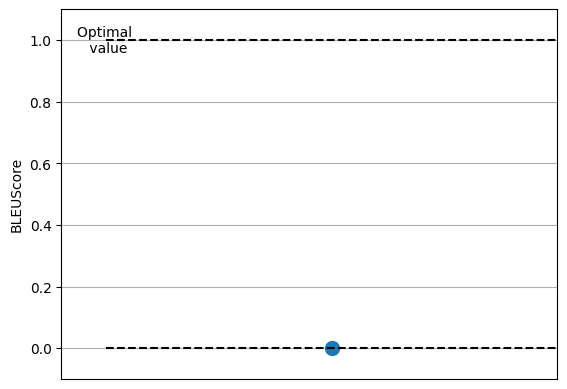

In [111]:
fig_, ax_ = bleu_val.plot() 

In [112]:
bleu_train.update(np.array(train_preds_sentences) , np.array([train_trg_sentences]))  

In [ ]:
fig_, ax_ = bleu_train.plot() 

In [ ]:
bleu_train_score = bleu_train(pad_train_preds_sentences , [pad_train_trg_sentences])

In [ ]:
bleu_val_score= bleu_val(pad_val_preds_sentences , [pad_val_trg_sentences])

In [ ]:
print(f'BLEU Train Score : {bleu_train_score.item()*100:.2f} % ')
print(f'BLEU VAL Score   : {bleu_val_score.item()*100:.2f} % ')

In [ ]:
from torchmetrics.text import WordErrorRate
WER_val = WordErrorRate()
WER_train = WordErrorRate()
#This value indicates the percentage of words that were incorrectly predicted.
#The lower the value,
#the better the performance of the ASR system with a WER of 0 being a perfect score

In [ ]:
WER_val.update(val_preds_sentences , val_trg_sentences)

In [ ]:
fig_, ax_ = WER_val.plot()

In [ ]:
WER_train.update(train_preds_sentences , train_trg_sentences)

In [ ]:
fig_, ax_ = WER_train.plot()

In [ ]:
WER_val_score = WER_val(val_preds_sentences , val_trg_sentences)

In [ ]:
WER_train_score = WER_val(train_preds_sentences , train_trg_sentences)

In [ ]:
print(f'WER Train Score : {WER_train_score.item()*100:.2f} % ')
print(f'WER VAL Score   : {WER_val_score.item()*100:.2f} % ')